In [3]:
import os
import math
import numpy as np
import pandas as pd
import ccxt
import talib
from datetime import datetime
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from script.fetch_history_data import binance_fetch_history_price, binance_single_fetch_history_price
from script.preprocess import *
#from script.transformer_timestep import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [21]:
# df2_0 = pd.read_pickle('./data/multi_factor_v2.0.0.pickle')
# timeframes = [10,20,40,60,80,100,120,140,160,180,200]
# df2_0 = calculate_technical_indicators(df2_0, timeframes=timeframes)
# ma_ptc_col = [col for col in df2_0.columns if 'MA_ptc' in col and 'Volume' not in col]
# ma_ptc_col_min = min(df2_0[ma_ptc_col].min(axis=0))
# ma_ptc_col_max = max(df2_0[ma_ptc_col].max(axis=0))
# # for col in ma_ptc_col:
# #     df[col] = (df[col] - ma_ptc_col_min) / (ma_ptc_col_max - ma_ptc_col_min)

In [28]:
# df2_0['Close_MA_ptc_10_minmax'] = (df2_0['Close_MA_ptc_10'] - ma_ptc_col_min) / (ma_ptc_col_max - ma_ptc_col_min)

In [32]:
# df2_0['Close_MA_ptc_10_minmax_restore'] = df2_0['Close_MA_ptc_10_minmax'] * (ma_ptc_col_max - ma_ptc_col_min) + ma_ptc_col_min

In [9]:
# df2_0[['Close_MA_10','Close_MA_ptc_10','Close_MA_ptc_10_minmax','Close_MA_ptc_10_minmax_restore']]

In [4]:
testdf = pd.read_pickle('./output_file/20230315_multi_factor_v2.0.0.pickle')

In [5]:
testdf = testdf.reset_index(drop=True).fillna('-')

In [10]:
ma_ptc_col_min = -0.04326610844852674
ma_ptc_col_max = 0.03996161803797027
restored_df = restore_close_price(testdf, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128)

In [43]:
restored_df.to_pickle('./output_file/20230315_multi_factor_v2.0.0_evaluation.pickle')

In [6]:
ma_ptc_col_min = -0.04326610844852674
ma_ptc_col_max = 0.03996161803797027

In [7]:
def restore_close_price(df, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128):
    input_df = df.copy()
    # restore min mnax
    input_df[target_col][seq_len:] = input_df[target_col][seq_len:]*(ma_ptc_col_max - ma_ptc_col_min) + ma_ptc_col_min
    restored_close_list = []
    for idx in range(seq_len, len(input_df)):
        previois_avg     = input_df.loc[idx - moving_avg_step : idx - 1 ,'Close'].mean()
        close_avg        = previois_avg * (input_df[target_col][idx] + 1)
        restored_close   = (close_avg * moving_avg_step) - (input_df.loc[idx - (moving_avg_step -1) : idx - 1, 'Close'].sum())
        restored_close_list.append(restored_close)
    input_df['pred_Close'] = '-'
    input_df['pred_Close'][seq_len:] = restored_close_list
    return input_df

In [49]:
testdf.loc[300-10:299,'Close'].mean()

16738.0

In [9]:
testdf['Close_MA_ptc_10'] = (testdf['Close_MA_ptc_10']+ ma_ptc_col_min)*(ma_ptc_col_max + ma_ptc_col_min)

In [11]:
testdf['Close_MA_ptc_10'][300]

-0.001541783053162728

In [41]:
16738.0 *  (-0.001541783053162728 + 1)

16712.19363525616

In [43]:
(16712.19363525616 * 10) - (testdf.loc[300 - (10 -1) : 300 - 1, 'Close'].sum())

16527.936352561606

In [17]:
testdf['Close_MA_ptc_10'] = (testdf['Close_MA_ptc_10'] + ma_ptc_col_min)*(ma_ptc_col_max + ma_ptc_col_min)

In [15]:
testdf['Close_MA_10'][299]*(-0.001541783053162728+1)

16712.19363525616

In [13]:
testdf['Close_MA_10'][300]

16724.05

In [20]:
(testdf['Close_MA_10'][300]* 10) - (testdf.loc[299 - 8: 299, 'Close'].sum())

16646.5

In [52]:
16724.05/16738.0 - 1

-0.0008334329071574276

In [54]:
16738.0*(-0.0008334329071574276+1)

16724.05

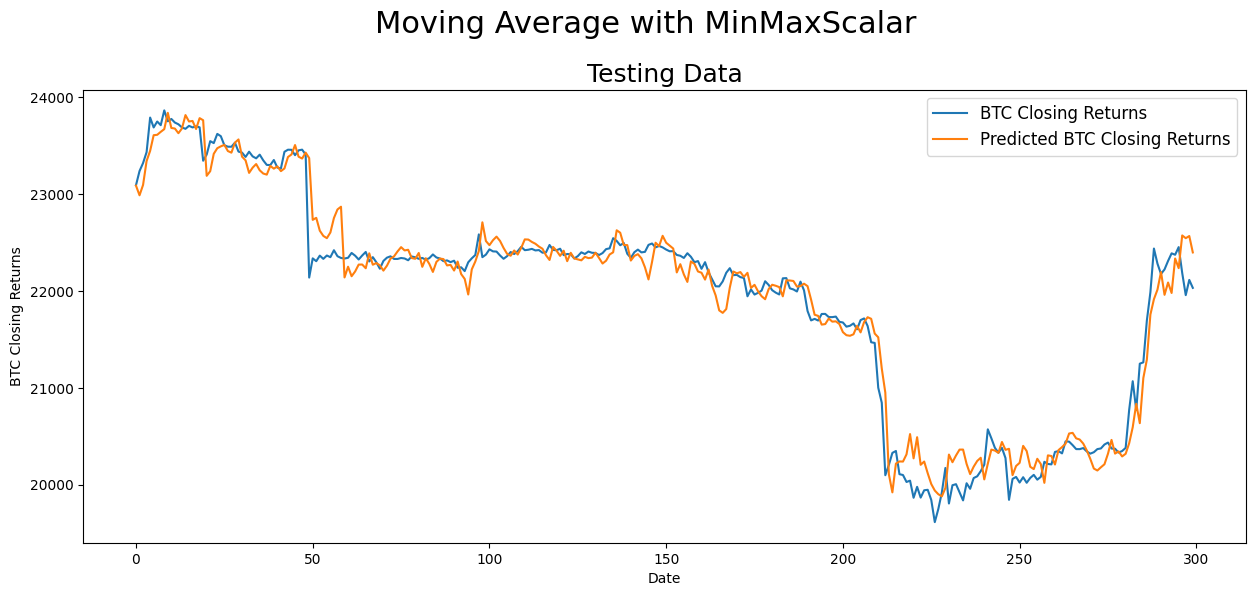

In [30]:
import matplotlib.pyplot as plt
seq_len = 128
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with MinMaxScalar", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(restored_df['Close'][-300:].values, label='BTC Closing Returns')
ax11.plot(np.arange(restored_df[-300:].shape[0]), restored_df['pred_Close'][-300:].values, label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

In [25]:
restored_df['Close'][-300:].values.shape[0]

300

In [27]:
restored_df['pred_Close'][-300:].values.shape[0]

300